<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/RaciallyBiasedDecisions/RaciallyBiasedDecisions_APF/behavioral/code/RBD_IAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
#@title Import libraries
import pandas as pd #for dealing with csv import
import os # for joining paths and filenames sensibly
import numpy as np #for the population std
import glob # for finding csv data files
import platform # paths use different dividers on linux vs windows, so we need to test for this
import string
from scipy.stats import sem
import matplotlib.pyplot as plt

In [261]:
#@title Define Utility functions
#Compute adjusted mean
def adjustedmean(RTs,corrs,penalty):
    n=len(corrs) #trials
    n_errors=int(n-sum(corrs)) #errors
    # print("Number of correctness: ", int(sum(corrs)))
    # print("Number of errors: ", n_errors)
    cor_RTs=np.array(corrs)*RTs #sum of correct RTs
    cor_mean=sum(cor_RTs)/sum(corrs)

    #mean with errors replaced with penalty value
    return cor_mean+(n_errors*penalty)/n


#Remove timed out trials
def exclude_slows(RTs,corrs,slowRT_limit):
    new_rt=[] #holding variables
    new_cr=[]
    for i in range(len(RTs)): #iterate over every item
        if RTs[i] < slowRT_limit: #if it isn't too fast, include RT and corr values
            new_rt.append(RTs[i])
            new_cr.append(corrs[i])

    return (new_rt, new_cr)

#Compute IAT bias rating
def iat_analyze(congr_rts_raw, congr_corr_raw, incon_rts_raw, incon_corr_raw, df_name):
    #1 discard subject if too many fast responses
    if sum(np.array(np.concatenate((np.array(congr_rts_raw), np.array(incon_rts_raw))))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_raw), np.array(incon_rts_raw))))*fast_prop_limit:
        print ("excluding subject because too many fast responses")
    else:
        #2 Eliminate scores over 10,000 ms

        congr_rts,congr_corr=exclude_slows(congr_rts_raw,congr_corr_raw,slowRT_limit)
        incon_rts,incon_corr=exclude_slows(incon_rts_raw,incon_corr_raw,slowRT_limit)

        #3 Calculate pooled std
        #pooled_std=pooled.std(0) #n-1 std sample std
        #(Use N not N-1 because this is the whole sample).
        #numpy.std is population std
        pooled=pd.concat([congr_rts_raw,incon_rts_raw]) #all RTs from both blocks, correct and incorrect
        pooled_std=np.std(pooled)

        #4 Calculated adjusted means, including the penalty
        congr_adjmean=adjustedmean(congr_rts,congr_corr,penalty)
        incon_adjmean=adjustedmean(incon_rts,incon_corr,penalty)

        #5 Calculate the IAT, so that pro-stereotype RTs are a -ve score
        IAT=(congr_adjmean-incon_adjmean)/pooled_std

        simpleIAT=sum(congr_rts)/len(congr_rts)-sum(incon_rts)/len(incon_rts)

        return(IAT)
        print("IAT for " + df_name + " is : {:+.3f}".format(IAT))
        print("Mean difference (uncorrected) " + df_name + " is {:+.3f}".format(simpleIAT)+" seconds")

In [262]:
#@title Load data
IAT_C= pd.read_csv ('https://raw.githubusercontent.com/ExCaLBBR/ExCaLBBR_Projects/main/RaciallyBiasedDecisions/RaciallyBiasedDecisions_APF/behavioral/data/IAT_C.csv', header=0)
IAT_W = pd.read_csv ('https://raw.githubusercontent.com/ExCaLBBR/ExCaLBBR_Projects/main/RaciallyBiasedDecisions/RaciallyBiasedDecisions_APF/behavioral/data/IAT_W.csv', header=0)

In [263]:
#@title Specify thresholds
penalty=0.600 #penalty - in seconds - for incorrect responses
slowRT_limit=10000 #threshold at which slow RTs are discarded
fastRT_limit=300 #threshold which defines responses which are "too fast" degault = 300
fast_prop_limit=0.1 # threshold proportion of "too fast" responses which defines exclusion of ppt


In [264]:
#@title Data subsetting and recoding

#Correct ID formatting
IAT_C['Participant Private ID'] = [int(sub) for sub in IAT_C['Participant Private ID']]
IAT_C['Participant Private ID'] = IAT_C['Participant Private ID'].astype(str)
IAT_W['Participant Private ID'] = [int(sub) for sub in IAT_W['Participant Private ID']]
IAT_W['Participant Private ID'] = IAT_W['Participant Private ID'].astype(str)


In [265]:
#@title Filter participants who are too fast
#Find and remove participants who are too fast

# C Int/Str/Dis
C_ID = np.unique(IAT_C['Participant Private ID'])
remIndx = []
for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']
  if sum(np.array(np.concatenate((np.array(datpi_congInt_rt), np.array(datpi_incongInt_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congInt_rt), np.array(datpi_incongInt_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for C Int because too many fast responses")
    remIndx.append(p)

for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']
  if sum(np.array(np.concatenate((np.array(datpi_congStr_rt), np.array(datpi_incongStr_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congStr_rt), np.array(datpi_incongStr_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for C STR because too many fast responses")
    remIndx.append(p)

for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']
  if sum(np.array(np.concatenate((np.array(datpi_congDis_rt), np.array(datpi_incongDis_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congDis_rt), np.array(datpi_incongDis_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for C Dir because too many fast responses")
    remIndx.append(p)

for p in np.unique(remIndx):
  IAT_C = IAT_C[IAT_C['Participant Private ID'] != p]

# W Int/Str/Dis
W_ID = np.unique(IAT_W['Participant Private ID'])
remIndx = []
for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']
  if sum(np.array(np.concatenate((np.array(datpi_congInt_rt), np.array(datpi_incongInt_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congInt_rt), np.array(datpi_incongInt_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for W Int because too many fast responses")
    remIndx.append(p)

for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']
  if sum(np.array(np.concatenate((np.array(datpi_congStr_rt), np.array(datpi_incongStr_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congStr_rt), np.array(datpi_incongStr_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for W STR because too many fast responses")
    remIndx.append(p)

for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']
  if sum(np.array(np.concatenate((np.array(datpi_congDis_rt), np.array(datpi_incongDis_rt))))<fastRT_limit)>len(np.concatenate((np.array(datpi_congDis_rt), np.array(datpi_incongDis_rt))))*fast_prop_limit:
    print ("Excluding subject", p, "for W Dir because too many fast responses")
    remIndx.append(p)

for p in np.unique(remIndx):
  IAT_W = IAT_W[IAT_W['Participant Private ID'] != p]

Excluding subject 9394769 for C Int because too many fast responses
Excluding subject 9853067 for C Int because too many fast responses
Excluding subject 9394769 for C Dir because too many fast responses
Excluding subject 9362255 for W Int because too many fast responses
Excluding subject 9362325 for W Int because too many fast responses
Excluding subject 9362330 for W Int because too many fast responses
Excluding subject 9362347 for W Int because too many fast responses
Excluding subject 9362360 for W Int because too many fast responses
Excluding subject 9852775 for W Int because too many fast responses
Excluding subject 9852778 for W Int because too many fast responses
Excluding subject 9852779 for W Int because too many fast responses
Excluding subject 9852832 for W Int because too many fast responses
Excluding subject 9852840 for W Int because too many fast responses
Excluding subject 9852845 for W Int because too many fast responses
Excluding subject 9362255 for W STR because too 

In [266]:
#@title Compute participant-wise IAT bias

# Chinese Participant Intel
C_ID = np.unique(IAT_C['Participant Private ID'])
C_IAT_INT = []
C_IAT_INT_simple = []
C_IAT_INT_acc = []
for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']
  datpi_congInt_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']

  #reset indeces for function
  datpi_congInt_rt = datpi_congInt_rt.reset_index(drop=True); datpi_incongInt_rt = datpi_incongInt_rt.reset_index(drop=True); datpi_congInt_acc = datpi_congInt_acc.reset_index(drop=True); datpi_incongInt_acc = datpi_incongInt_acc.reset_index(drop=True)
  iatSimple = np.mean(datpi_congInt_rt) - np.mean(datpi_incongInt_rt)
  iatBias = iat_analyze(datpi_congInt_rt, datpi_congInt_acc, datpi_incongInt_rt, datpi_incongInt_acc, "C Int")

  acc=(np.sum(pd.concat([datpi_congInt_acc,datpi_incongInt_acc]))/len(pd.concat([datpi_congInt_acc ,datpi_incongInt_acc])))
  C_IAT_INT_acc.append(acc)
  C_IAT_INT.append(iatBias)
  C_IAT_INT_simple.append(iatSimple)
  del datpi, datpi_congInt_rt, datpi_incongInt_rt, datpi_congInt_acc, datpi_incongInt_acc, iatSimple, iatBias, acc

# Chinese Participant Strength
C_IAT_STR = []
C_IAT_STR_simple = []
C_IAT_STR_acc = []
for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']
  datpi_congStr_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']

  #reset indeces for function
  datpi_congStr_rt = datpi_congStr_rt.reset_index(drop=True); datpi_incongStr_rt = datpi_incongStr_rt.reset_index(drop=True); datpi_congStr_acc = datpi_congStr_acc.reset_index(drop=True); datpi_incongStr_acc = datpi_incongStr_acc.reset_index(drop=True)

  iatSimple = np.mean(datpi_congStr_rt) - np.mean(datpi_incongStr_rt)
  iatBias = iat_analyze(datpi_congStr_rt, datpi_congStr_acc, datpi_incongStr_rt, datpi_incongStr_acc, "C Str")

  acc=(np.sum(pd.concat([datpi_congStr_acc,datpi_incongStr_acc]))/len(pd.concat([datpi_congStr_acc ,datpi_incongStr_acc])))
  C_IAT_STR_acc.append(acc)
  C_IAT_STR.append(iatBias)
  C_IAT_STR_simple.append(iatSimple)

# Chinese Participant Disgust
C_IAT_Disgust = []
C_IAT_Disgust_simple = []
for p in C_ID:
  datpi = IAT_C.loc[IAT_C['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']
  datpi_congDis_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']

  #reset indeces for function
  datpi_congDis_rt = datpi_congDis_rt.reset_index(drop=True); datpi_incongDis_rt = datpi_incongDis_rt.reset_index(drop=True); datpi_congDis_acc = datpi_congDis_acc.reset_index(drop=True); datpi_incongDis_acc = datpi_incongDis_acc.reset_index(drop=True)

  iatSimple = np.mean(datpi_congDis_rt) - np.mean(datpi_incongDis_rt)
  iatBias = iat_analyze(datpi_congDis_rt, datpi_congDis_acc, datpi_incongDis_rt, datpi_incongDis_acc, "C Disgust")
  C_IAT_Disgust.append(iatBias)
  C_IAT_Disgust_simple.append(iatSimple)



# White Participant Intel
W_ID = np.unique(IAT_W['Participant Private ID'])
W_IAT_INT = []
W_IAT_INT_simple = []
for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']
  datpi_congInt_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Int']
  datpi_incongInt_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Int']

  #reset indeces for function
  datpi_congInt_rt = datpi_congInt_rt.reset_index(drop=True); datpi_incongInt_rt = datpi_incongInt_rt.reset_index(drop=True); datpi_congInt_acc = datpi_congInt_acc.reset_index(drop=True); datpi_incongInt_acc = datpi_incongInt_acc.reset_index(drop=True)

  iatSimple = np.mean(datpi_congInt_rt) - np.mean(datpi_incongInt_rt)
  iatBias = iat_analyze(datpi_congInt_rt, datpi_congInt_acc, datpi_incongInt_rt, datpi_incongInt_acc, "C Int")
  W_IAT_INT.append(iatBias)
  W_IAT_INT_simple.append(iatSimple)

# White Participant Strength
W_IAT_STR = []
W_IAT_STR_simple = []
for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']
  datpi_congStr_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Str']
  datpi_incongStr_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Str']

  #reset indeces for function
  datpi_congStr_rt = datpi_congStr_rt.reset_index(drop=True); datpi_incongStr_rt = datpi_incongStr_rt.reset_index(drop=True); datpi_congStr_acc = datpi_congStr_acc.reset_index(drop=True); datpi_incongStr_acc = datpi_incongStr_acc.reset_index(drop=True)

  iatSimple = np.mean(datpi_congStr_rt) - np.mean(datpi_incongStr_rt)
  iatBias = iat_analyze(datpi_congStr_rt, datpi_congStr_acc, datpi_incongStr_rt, datpi_incongStr_acc, "C Str")
  W_IAT_STR.append(iatBias)
  W_IAT_STR_simple.append(iatSimple)

# White Participant Disgust
W_IAT_Disgust = []
W_IAT_Disgust_simple = []
for p in W_ID:
  datpi = IAT_W.loc[IAT_W['Participant Private ID'] == p] #get index for all trials with participant p
  datpi_congDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_rt = datpi['Absolute Reaction Time'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']
  datpi_congDis_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'cong_Dir']
  datpi_incongDis_acc = datpi['Correct'].loc[datpi['Spreadsheet: metadata2']== 'incon_Dir']

  #reset indeces for function
  datpi_congDis_rt = datpi_congDis_rt.reset_index(drop=True); datpi_incongDis_rt = datpi_incongDis_rt.reset_index(drop=True); datpi_congDis_acc = datpi_congDis_acc.reset_index(drop=True); datpi_incongDis_acc = datpi_incongDis_acc.reset_index(drop=True)

  iatSimple = np.mean(datpi_congDis_rt) - np.mean(datpi_incongDis_rt)
  iatBias = iat_analyze(datpi_congDis_rt, datpi_congDis_acc, datpi_incongDis_rt, datpi_incongDis_acc, "C Disgust")
  W_IAT_Disgust.append(iatBias)
  W_IAT_Disgust_simple.append(iatSimple)

In [268]:
#@title Participant-wise analysis of IAT bias by Stereotype category

#Chinese participant Stereotype endorsement
C_IAT_INT_Avg = np.mean(C_IAT_INT)
C_IAT_STR_Avg = np.mean(C_IAT_STR)
C_IAT_DIS_Avg = np.mean(C_IAT_Disgust)

C_IAT_INT_sd = np.std(C_IAT_INT)
C_IAT_STR_sd = np.std(C_IAT_STR)
C_IAT_DIS_sd = np.std(C_IAT_Disgust)


#White participant Stereotype endorsement
W_IAT_INT_Avg = np.mean(W_IAT_INT)
W_IAT_STR_Avg = np.mean(W_IAT_STR)
W_IAT_DIS_Avg = np.mean(W_IAT_Disgust)

W_IAT_INT_sd = np.std(W_IAT_INT)
W_IAT_STR_sd = np.std(W_IAT_STR)
W_IAT_DIS_sd = np.std(W_IAT_Disgust)

#Print output
print("Chinese Participant Intelligence Stereotype IAT bias =", round(C_IAT_INT_Avg,2), "(SD = ", round(C_IAT_INT_sd,2), ")")
print("Chinese Participant Strength Stereotype IAT bias =", round(C_IAT_STR_Avg,2), "(SD = ", round(C_IAT_STR_sd,2), ")")
print("Chinese Participant Disgust Stereotype IAT bias =", round(C_IAT_DIS_Avg,2), "(SD = ", round(C_IAT_DIS_sd,2), ")")

print("White Participant Intelligence Stereotype IAT bias =", round(W_IAT_INT_Avg,2), "(SD = ", round(W_IAT_INT_sd,2), ")")
print("White Participant Strength Stereotype IAT bias =", round(W_IAT_STR_Avg,2), "(SD = ", round(W_IAT_STR_sd,2), ")")
print("White Participant Disgust Stereotype IAT bias =", round(W_IAT_DIS_Avg,2), "(SD = ", round(W_IAT_DIS_sd,2), ")")

print('For Intelligence: positive values mean the group thinks White is more dumb; negative is the opposite')
print('For Strength: positive values mean the group thinks White is stronger; negative is the opposite')
print('For Disgust: positive values mean the group thinks White is more dirty; negative is the opposite')

Chinese Participant Intelligence Stereotype IAT bias = 0.07 (SD =  0.41 )
Chinese Participant Strength Stereotype IAT bias = 0.05 (SD =  0.39 )
Chinese Participant Disgust Stereotype IAT bias = 0.02 (SD =  0.44 )
White Participant Intelligence Stereotype IAT bias = -0.04 (SD =  0.47 )
White Participant Strength Stereotype IAT bias = 0.1 (SD =  0.33 )
White Participant Disgust Stereotype IAT bias = -0.02 (SD =  0.39 )
For Intelligence: positive values mean the group thinks White is less intelligent; negative is the opposite
For Strength: positive values mean the group thinks White is stronger; negative is the opposite
For Disgust: positive values mean the group thinks White is more dirty; negative is the opposite


Text(0, 0.5, 'White sample histogram')

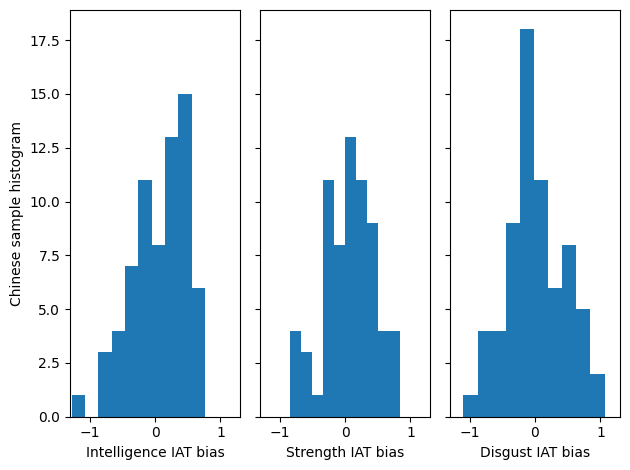

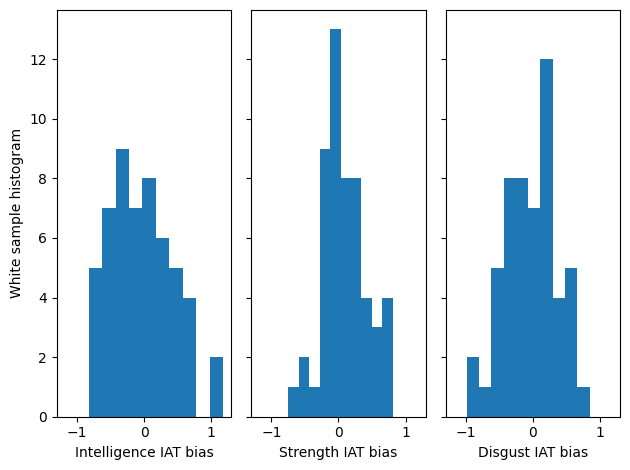

In [115]:
# @title IAT Histograms
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(C_IAT_INT)
axs[0].set_xlim(left=-1.3, right=1.3)
axs[0].set_xlabel('Intelligence IAT bias')
axs[1].hist(C_IAT_STR)
axs[1].set_xlim(left=-1.3, right=1.3)
axs[1].set_xlabel('Strength IAT bias')
axs[2].hist(C_IAT_Disgust)
axs[2].set_xlim(left=-1.3, right=1.3)
axs[2].set_xlabel('Disgust IAT bias')
axs[0].set_ylabel('Chinese sample histogram')

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(W_IAT_INT)
axs[0].set_xlim(left=-1.3, right=1.3)
axs[0].set_xlabel('Intelligence IAT bias')
axs[1].hist(W_IAT_STR)
axs[1].set_xlim(left=-1.3, right=1.3)
axs[1].set_xlabel('Strength IAT bias')
axs[2].hist(W_IAT_Disgust)
axs[2].set_xlim(left=-1.3, right=1.3)
axs[2].set_xlabel('Disgust IAT bias')
axs[0].set_ylabel('White sample histogram')

In [116]:

from scipy import stats
print('Intelligence T-test results:',stats.ttest_ind(C_IAT_INT,W_IAT_INT, permutations=10000, equal_var=False))
print('Strength T-test results:',stats.ttest_ind(C_IAT_STR,W_IAT_STR, permutations=10000, equal_var=False))
print('Disgust T-test results:',stats.ttest_ind(C_IAT_Disgust,W_IAT_Disgust, permutations=10000, equal_var=False))

Intelligence T-test results: TtestResult(statistic=1.3723569839397702, pvalue=0.17848215178482152, df=nan)
Strength T-test results: TtestResult(statistic=-0.6728296807889553, pvalue=0.5018498150184981, df=nan)
Disgust T-test results: TtestResult(statistic=0.6260454123771461, pvalue=0.5387461253874612, df=nan)


In [117]:
#@title Participant-wise analysis of simple IAT bias by Stereotype category

#Chinese participant Stereotype endorsement
C_IAT_INT_Avg = np.mean(C_IAT_INT_simple)
C_IAT_STR_Avg = np.mean(C_IAT_STR_simple)
C_IAT_DIS_Avg = np.mean(C_IAT_Disgust_simple)

C_IAT_INT_sd = np.std(C_IAT_INT_simple)
C_IAT_STR_sd = np.std(C_IAT_STR_simple)
C_IAT_DIS_sd = np.std(C_IAT_Disgust_simple)


#White participant Stereotype endorsement
W_IAT_INT_Avg = np.mean(W_IAT_INT_simple)
W_IAT_STR_Avg = np.mean(W_IAT_STR_simple)
W_IAT_DIS_Avg = np.mean(W_IAT_Disgust_simple)

W_IAT_INT_sd = np.std(W_IAT_INT_simple)
W_IAT_STR_sd = np.std(W_IAT_STR_simple)
W_IAT_DIS_sd = np.std(W_IAT_Disgust_simple)

#Print output
print("Chinese Participant Intelligence Stereotype simple IAT bias =", round(C_IAT_INT_Avg,2), "(SD = ", round(C_IAT_INT_sd,2), ")")
print("Chinese Participant Strength Stereotype simple IAT bias =", round(C_IAT_STR_Avg,2), "(SD = ", round(C_IAT_STR_sd,2), ")")
print("Chinese Participant Disgust Stereotype simple IAT bias =", round(C_IAT_DIS_Avg,2), "(SD = ", round(C_IAT_DIS_sd,2), ")")

print("White Participant Intelligence Stereotype simple IAT bias =", round(W_IAT_INT_Avg,2), "(SD = ", round(W_IAT_INT_sd,2), ")")
print("White Participant Strength Stereotype simple IAT bias =", round(W_IAT_STR_Avg,2), "(SD = ", round(W_IAT_STR_sd,2), ")")
print("White Participant Disgust Stereotype simple IAT bias =", round(W_IAT_DIS_Avg,2), "(SD = ", round(W_IAT_DIS_sd,2), ")")

print('For Intelligence: positive values mean the group thinks White is more intelligent; negative is the opposite')
print('For Strength: positive values mean the group thinks White is weaker; negative is the opposite')
print('For Disgust: positive values mean the group thinks White is more clean; negative is the opposite')

Chinese Participant Intelligence Stereotype simple IAT bias = 55.97 (SD =  259.71 )
Chinese Participant Strength Stereotype simple IAT bias = -77.95 (SD =  1007.44 )
Chinese Participant Disgust Stereotype simple IAT bias = 35.74 (SD =  293.88 )
White Participant Intelligence Stereotype simple IAT bias = -28.51 (SD =  305.08 )
White Participant Strength Stereotype simple IAT bias = 12.45 (SD =  176.15 )
White Participant Disgust Stereotype simple IAT bias = -22.38 (SD =  224.57 )
For Intelligence: positive values mean the group thinks White is more intelligent; negative is the opposite
For Strength: positive values mean the group thinks White is weaker; negative is the opposite
For Disgust: positive values mean the group thinks White is more clean; negative is the opposite


In [269]:
#Format dataframe for saving
C_ID = np.unique(IAT_C['Participant Private ID'])
C_IAT_df = pd.DataFrame({'Participant Private ID':C_ID,'C_IAT_INT(pos=Wint)':C_IAT_INT, 'C_IAT_STR(pos=Wweak)':C_IAT_STR, 'C_IAT_Disgust(pos=Wclean)':C_IAT_Disgust})

W_ID = np.unique(IAT_W['Participant Private ID'])
W_IAT_df = pd.DataFrame({'Participant Private ID':W_ID,'W_IAT_INT(pos=Wint)':W_IAT_INT, 'W_IAT_STR(pos=Wweak)':W_IAT_STR, 'W_IAT_Disgust(pos=Wclean)':W_IAT_Disgust})


In [270]:
#Convert all files to csv
C_IAT_df.to_csv('C_IAT_df.csv')
W_IAT_df.to_csv('W_IAT_df.csv')

## Reference:
IAT data analysis script adapted from https://github.com/tomstafford/IAT

Calculate IAT score from data generated by Robin's PsychoPy script [TQS Feb 2014]

*Greenwald, A. G., Nosek, B. A., & Banaji, M. R. (2003). Understanding and using the implicit association test: I. An improved scoring algorithm. Journal of personality and social psychology, 85(2), 1972-216.*